# Recruitment task for the position of an Trainee Machine Learning Engineer #
Amazon reviews - data analysis with machine learning and natural language processing elements <br>
Daniel Jankowski <br>
<br>
<br>
Table of contents
1. [Number of selling products depending on the month of the year](#first)
2. [Which products are the most frequently reviewed?: Product Clustering](#cluster)<br>
    2.1. [Top 10 products](#top)<br>
    2.2. [Product clustering](#clustering)<br>
    &emsp;    2.2.1 [Text preprocessing](#textpre)<br>
    &emsp;    2.2.2 [Vectorization of the data](#vector)<br>
    &emsp;    2.2.3 [Building clustering model](#clustermodel)<br>
     &emsp;   2.2.4 [Analysis of the results](#analysis)<br>
3. [Analysis of purchases of customers, who have issued more than one review](#customers)
4. [Positive vs. negative reviews](#rev)<br>
    4.1. [Examination and analysis of selected data](#exam)<br>
    4.2. [Bonus part: Review classification model](#bonus)    
    &emsp;4.2.1 [Preprocessing data](#predata)<br>
    &emsp;4.2.2 [Vectorize data and split it into training and test sets](#split)<br>
    &emsp;4.2.3 [Building classification model](#mlmodel)<br>
    &emsp;4.2.4 [Model training and evalution](#eval)





In [227]:
#import neccesary libraries
#library for reading data from file
import gzip
#common libraries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
#data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
#ML libraries
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
#libraries for data vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
#libraries for data pre-processing and NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
import re
import string
import webcolors
#library for finding associate rules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [144]:
#read the data as pandas dataframe
df = pd.DataFrame(data)
#rename columns
df.columns = ['productID','product','price','userID','profile','helpfulness','score','date','summary','text']

#Replace all 'unknown' and empty values with None
df = df.replace({'unknown': None, '': None, ' ': None})

#Convert column types
df[['price','score','date']] = df[['price','score','date']].apply(pd.to_numeric)
df['date'] = pd.to_datetime(df['date'], unit='s')
df[['productID','product','userID','profile','helpfulness','summary','text']] = \
    df[['productID','product','userID','profile','helpfulness','summary','text']].astype("string")


# <a name="first"></a>Number of selling products depending on the month of the year #


In the beginning I decided to conduct a simple and predictable analysis of the number of products sold in each month of the year. As we all probably expect, the sales increases during the Christmas Time, when people usually buy gifts for their family. The only problem, which we actually have to think about is fact that our data consists of customers reviews, not about customer purchases. To simplify, we actually have a date of opinion, not the date of purchase, and as we know, customers can give their feedback a long time after they purchase the product.

However, for the purpose of analysis, we can assume that most of the customers leave their feedback within one to two months of making the purchase. If our assumption is correct, we should clearly see the <b>increases number of reviews given in January or even in February.</b> Those two months are expected as the months, when customers leave their feedback about product, which they had bought during the Christmas Time.

In [145]:
#Create copy of original dataframe
df_sales = df.copy()
#Extract the month from the datatime
df_sales['month'] = df_sales['date'].dt.month

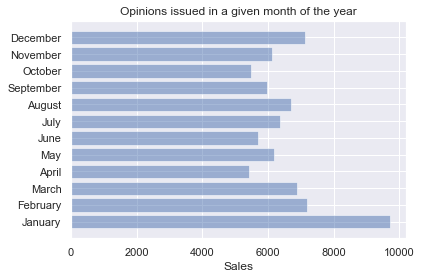

In [146]:
import calendar
#Number of reviews in all months
month_sales = df_sales['month'].value_counts().sort_index()
months = list(calendar.month_name)[1:]

plt.barh(months, month_sales, align='center')
plt.xlabel('Sales')
plt.title('Opinions issued in a given month of the year')

plt.show()
# month_sales

As we can see in the above chart our assumption and expectations occurs to be true. There is many more reviews given in January than other months of the year. December is in second place with a slight advantage over February.

These observations allow us to confirm not only that much more purchases are made during the holiday season than in the rest of the year, but also that customers most often leave their opinions within a month of making a purchase.

# <a name="cluster"></a>Which products are the most frequently reviewed?: Product Clustering #

When runnning online stores, it is very useful to analyze which products are selling the best in order to be able to recommend products to customers more effectively or plan new advertising campaigns.




## <a name="top"></a>Top 10 products ##

As a warmup analysis I would like to extract from our dataset top 10 products.

In [147]:
#Copy of original df
df_products = df.copy()
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78931 entries, 0 to 78930
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   productID    78930 non-null  string        
 1   product      78383 non-null  string        
 2   price        35643 non-null  float64       
 3   userID       76654 non-null  string        
 4   profile      76654 non-null  string        
 5   helpfulness  78930 non-null  string        
 6   score        78930 non-null  float64       
 7   date         78930 non-null  datetime64[ns]
 8   summary      78928 non-null  string        
 9   text         78930 non-null  string        
dtypes: datetime64[ns](1), float64(2), string(7)
memory usage: 6.0 MB


There is one row where `productID` is `None`, so we won't take that row into account. Moreover, some of the rows have a `None` value in `product` attribute. We can check whether we are able to fill some of these missing values.

In [148]:
#Omit one row with None productID
df_products = df_products[df_products['productID'].notna()]
#Check if one product has different values in its name field, i.e. proper name and None value
df_products.groupby('productID')['product'].nunique(dropna=False).sort_values(ascending=False)


productID
1588465934    1
B000ID1G0W    1
B000IEFILY    1
B000IEDH9E    1
B000IED9GA    1
             ..
B000AAYEZC    1
B000AATKBA    1
B000AANVAG    1
B000AALYOG    1
B000UUEH04    1
Name: product, Length: 7438, dtype: int64

All of the products have maximum one unique `product` attribute value. Therefore, each of the product have either a proper filled name or have a `None` value. Unfortunately, we are not able to fill any missing values of `product` attribute in that case. 

In [149]:
#Compute frequency of reviewing products with their score mean
prod_rank = df_products.groupby('productID').agg({'userID':'size', 'score':'mean'}) \
    .rename(columns={'userID':'product_frequency','score':'mean_score'}) \
        .reset_index()

In [150]:
top_products = prod_rank[prod_rank['mean_score'] >= 4.0] \
    .sort_values(by='product_frequency', ascending=False)\
        .head(10)
top_products


,productID,product_frequency,mean_score
2216,B0009B0IX4,3443,4.161778
7244,B000Q6R4MK,515,4.058252
1912,B0007N08NO,344,4.380814
686,B00009J5VV,302,4.006623
5153,B000J2FOF0,190,4.068421
3854,B000FL9QGI,184,4.250000
3674,B000F9LRYO,163,4.110429
6896,B000PB8CQI,145,4.613793
4900,B000I8FL0S,138,4.347826
5835,B000LGE1LW,137,4.343066


As a selection criterion of the best products I decided to base most on the number of reviews. As we don't want to make a very bad product with `mean_score` = 1.0 at the top, another criterion was that the item has to have the `mean_score` >= 4.0. Finally we get the list of 10 the best selling products with score above or equal to 4.0.

Since the `productID` tells us little, below there is a table with products name instead of ID's.

In [151]:
prod_ids = top_products['productID'].to_numpy()
top_prod_names = df_products[df_products['productID'].isin(prod_ids)][['productID','product']]
pd.merge(top_prod_names.drop_duplicates(), top_products, on='productID')\
    .sort_values(by='product_frequency', ascending=False)

,productID,product,product_frequency,mean_score
3,B0009B0IX4,Plantronics Voyager 510 Bluetooth Headset [Ret...,3443,4.161778
1,B000Q6R4MK,BlueAnt Supertooth Light Bluetooth Speakerphon...,515,4.058252
2,B0007N08NO,Motorola Cigarette Lighter Adapter for Motorol...,344,4.380814
7,B00009J5VV,<NA>,302,4.006623
9,B000J2FOF0,"Sony Ericsson W810i Phone (AT&T, Phone Only, N...",190,4.068421
8,B000FL9QGI,BlueAnt Bluetooth Portable Handsfree Supertoot...,184,4.250000
4,B000F9LRYO,"Belkin TuneTalk Stereo for iPod 5G, 5.5G (Black)",163,4.110429
5,B000PB8CQI,Multi-Use Vehicle Charger with Dual USB Ports ...,145,4.613793
0,B000I8FL0S,BoxWave Galaxy Note 2 / Note DuoSuit - Slim-Fi...,138,4.347826
6,B000LGE1LW,BoxWave Galaxy Note 2 / Note DuoSuit - Slim-Fi...,137,4.343066


Creating such a rankings is always very exciting thing to do, but to be honest they are not really helpful. Let's say that we would like to somehow categorize our products and base on that, select the best products from each category. It's much better solution, because we would be able to recommend product from category, in which customers are looking for.

Since our data doesn't provide any categories of products, clustering techniques seems very good in that case. 



## <a name="clustering"></a> Product clustering ##

Scope of this section:
1. Text preprocessing
2. Vectorization of our data
3. Implementation of KMeans algorithm
4. Observations and analysis of obtained results

Because our problem is to cluster the products, we have to use product names for that purpose.

In [152]:
#load original data just in case
df_products = df.copy()
#since we work on product names, we have drop all the rows with None value in product field
df_products = df_products[df_products['product'].notna()]['product']\
    .drop_duplicates() #there is no need to keep all duplicates of products, therefore we drop duplicates
df_products.size

7149

There will be exactly $7149$ different products to cluster

### <a name="textpre"></a> Text preprocessing ###

At this step it's time to clean our data. I will remove from each product name punctuations, digits, stopwords. Because our data consists of products, which often has a specified color in their name, I will also remove colors from names, since we don't want to cluster our products based on colors. After that we will also lemmatize text, i.e. convert all words into their basic form.

In [153]:
df_products.head()

0     Mobile Action MA730 Handset Manager - Bluetoot...
3     USB Data Cable for Sony-Ericsson Z600, Z500, Z...
12    Motorola HT820 Stereo Bluetooth Headset with m...
18    Belkin Executive Leather Case handheld carryin...
19    Samsung T809 M620 i607 U420 A303 A717 Car Char...
Name: product, dtype: string

Moreover, I decided to drop the first word in each product name, because in most of cases it's the producer name of the product. Since we rather want to cluster product based on category (like 'Phones', 'Chargers' etc.) than based on the manufacturers I believe that the good thing to do.

In [154]:
# function, which preprocess our data. We lower text and
# remove punctuation, word with digits, digits, whitespaces.
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\w*\d\w*', '', text).strip() 
    text = re.sub(r'\d+', '', text)
    text = ''.join([i for i in text if i not in string.punctuation])
    text = text.strip()
    return text.split()[1:] #Return all words except the first one
to_remove = stopwords.words('english')
colors = list(webcolors.CSS3_NAMES_TO_HEX)
to_remove = np.concatenate((to_remove, colors), axis=None)

# function which will remove from given review all stopwords, 
# which occurs in english language (words like 'in','he,'where','when' etc.).
def remove_stopword(text):
    return np.setdiff1d(text, to_remove)

# function which will perform lemmatization of words in given review, 
# i.e. convert different forms of one word into one form,
# so they can be analysis as single word 
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    output = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(output)

In [155]:
# perform preprocessing on data
df_products = df_products.apply(lambda x: lemmatize_text(remove_stopword(preprocess(x))))
df_products.head()

0           action bluetooth data handset manager suite
3            cable cd data driver internet sonyericsson
12    bluetooth headset hour microphone music stereo...
18             carrying case executive handheld leather
19                                          car charger
Name: product, dtype: object

### <a name="vector"></a>Data vectorization ###

We know that Machine Learning is strictly connected to mathematics, hence we convert our text data into numerical form (to be more specific to the vectors form).

In [156]:
#create the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True,min_df=5, max_df=0.95)
#apply TD-IDF to the data
X = vectorizer.fit_transform(df_products)

### <a name="clustermodel"></a> Building Clustering model ###

Some useful functions

In [157]:
from mpl_toolkits import mplot3d

#plot elbow curve, based on that plot I'll chose the best optimal K.
def plot_elbow(K, distances):
    plt.plot(K, avg_distances, 'bx-')
    plt.xlabel("Value of K")
    plt.ylabel("Sum of squared distances")
    plt.title("Elbow method for selecting optimal K")
    plt.show()

#function which return top n words from each cluster
def get_top_keywords(n_terms, X):
    # groups the TF-IDF vector by cluster
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() 
    # access tf-idf terms
    terms = vectorizer.get_feature_names() 
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        # for each row of the dataframe, find the n terms that have the highest tf idf score
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) 

#function which plot our clusters
def plot_clusters(data):
    fig = plt.figure(1, figsize=(6,6))
    ax = plt.axes(projection="3d")
    ax.scatter3D(data['x0'],data['x1'],data['x2'], c=data['cluster'], cmap='rainbow')
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    ax.set_zlabel("x2")
    ax.set_facecolor('white')
    plt.title("Products clustering", fontsize=14)
    plt.show()

In [158]:
avg_distances = []
K = range(1,10)

for n_clusters in K:
    model = KMeans(n_clusters=n_clusters, random_state=12)
    model.fit(X)
    avg_distances.append(model.inertia_)

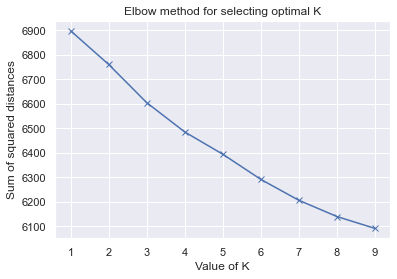

In [159]:
plot_elbow(K, avg_distances)

Actually the elbow here is not visible very good, this due the fact that our data are very similar to each other and the distance between the points and centroids decreases very slowly, nonetheless I decided to pick $K=8$.

In [160]:
model = KMeans(n_clusters=8, random_state=12)
model.fit(X)
clusters = model.labels_

In [161]:
# Decompose our product vectors
pca = PCA(n_components=3, random_state=12)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:,0]
x1 = pca_vecs[:,1]
x2 = pca_vecs[:,2]

In [162]:
df_products['cluster'] = clusters
df_products['x0'] = x0
df_products['x1'] = x1
df_products['x2'] = x2

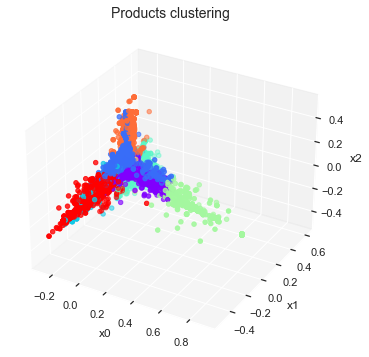


Cluster 0
screen,motorola,headset,pack,kit

Cluster 1
warranty,att,unlocked,cell,phone

Cluster 2
motorola,clip,belt,swivel,holster

Cluster 3
vehicle,wall,travel,car,charger

Cluster 4
bh,wireless,stereo,bluetooth,headset

Cluster 5
software,sync,usb,data,cable

Cluster 6
extended,lithiumion,oem,liion,battery

Cluster 7
motorola,cover,clip,leather,case


In [163]:
plot_clusters(df_products)
get_top_keywords(5, X)

Taking top 5 cluster keywords of each cluster, there is some similarity between the words. Below is my suggestion for category names.  

In [164]:
categories = {0: 'Accessories', 1: 'Phones', 2: 'Holsters', 3: 'Chargers', 4: 'Audio', 5: 'Data transfer', 6: 'Battery', 7: 'Phone case'}

In [165]:
#load original product names
products = df.copy()
products = products[products['product'].notna()]['product']\
    .drop_duplicates()
#convert series to dataframe object
products = products.to_frame()
products['cluster'] = df_products['cluster']
products.head()

,product,cluster
0,Mobile Action MA730 Handset Manager - Bluetoot...,5
3,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",5
12,Motorola HT820 Stereo Bluetooth Headset with m...,4
18,Belkin Executive Leather Case handheld carryin...,7
19,Samsung T809 M620 i607 U420 A303 A717 Car Char...,3


In [166]:
#Create df with product names, price, score, and clusters
df_products = df.copy()
df_products = df_products[['product','price','score']]
df_products = pd.merge(df_products, products, on='product', how='left')
#replace cluster number with name of category
df_products = df_products.replace({"cluster": categories})
df_products = df_products.rename(columns={'cluster':'category'})

### <a name="analysis"></a> Analysis of the results ###

Finally we obtain a dataframe with categorized products. Now, it's time to analyze the results. First of all, let's check whether created category labels makes sense.

In [167]:
df_products.head(30)

,product,price,score,category
0,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,1.0,Data transfer
1,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,5.0,Data transfer
2,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,4.0,Data transfer
3,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,4.0,Data transfer
4,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,1.0,Data transfer
5,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,4.0,Data transfer
6,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,5.0,Data transfer
7,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,1.0,Data transfer
8,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,3.0,Data transfer
9,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,4.0,Data transfer


Looking at first 30 rows, we see that our labels in general makes sense. Of course, it's not perfect and in our data for sure there are badly categorized products, nonetheless it looks good overall.

In [168]:
# count products grouped by categories
categories_count = df_products.groupby('category').count()
# mean of price and score grouped by categories
categories_mean = df_products.groupby('category').mean()
labels = df_products['category'].drop_duplicates().sort_values().to_numpy()[:8]
categories_count['category'] = labels
categories_mean['category'] = labels


<AxesSubplot:xlabel='category'>

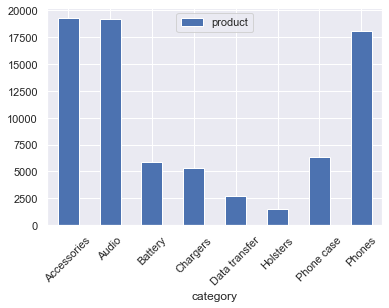

In [169]:
categories_count.plot.bar(x='category', y='product', rot=45)

Most of the reviews concern accesories, audio and phones. It is worth to notice that "more serious" categories have more reviews. By "more serious" I mean that average customer will buy a phone less often than a regular USB cable, mainly due to the price of the product and demand. My point is that the average user more likely leave opinions about the phone that an ordinary cable.

<AxesSubplot:xlabel='category'>

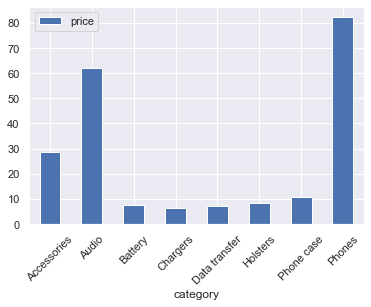

In [170]:
categories_mean.plot.bar(x='category', y='price', rot=45)

In [171]:
# check the correlation between number of reviews and average price of the product
df_correlation = pd.DataFrame()
df_correlation['count'] = categories_count['product']
df_correlation['price'] = categories_mean['price']
df_correlation.corr()

,count,price
count,1.000000,0.834089
price,0.834089,1.000000


<AxesSubplot:xlabel='count', ylabel='price'>

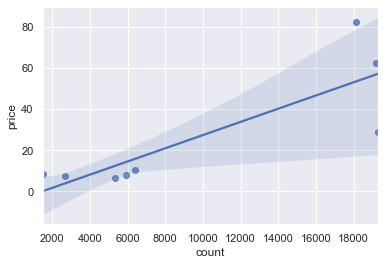

In [172]:
sns.regplot(x='count', y='price', data = df_correlation)

The data clearly shows, that there is a strong correlation between number of reviews and average product prices in given category. Three categories with the highest average price have also the largest number of issued reviews. This strictly confirms what I wrote above, customers are more likely to review more expensive products, because thats for them more serious purchases. 

Below there is a list of top 3 products of each category based on score and number of reviews. From each category I've choosen products, which average `score` was higher than average `score` obtained my whole category. At te end I sorted the list grouped by category based on number of reviews of each product.

In [173]:
products_mean = df_products.groupby('product')[['product','score']].mean()

In [174]:
#Merge product scores with their categories
products_mean = pd.merge(products_mean, df_products[['product','category']], on='product', how='left')
categories_mean = categories_mean.reset_index(drop=True)
#assign to each product, its mean score
products_mean = pd.merge(products_mean, categories_mean[['category','score']], on='category', how='left')
#compute frequency of each product
product_freq = df_products.groupby('product')['product'].count().reset_index(name='item')
products_mean = pd.merge(products_mean, product_freq, on='product', how='left')
products_mean = products_mean.drop_duplicates()

In [175]:
products_mean = products_mean.reset_index()
idx = products_mean.index[products_mean['score_x'] > products_mean['score_y']].to_list()
products_mean = products_mean.iloc[idx]
#Take top 3 products from each category
top_product = products_mean.sort_values(['category','item'], ascending=False).groupby('category')\
    [['product','score_x','category','score_y','item']]\
        .head(3)

In [176]:
#rename columns
top_product.rename(columns={'score_x': 'Product_score', 'score_y':'avg_category_score', 'item':'n_reviews'})

,product,Product_score,category,avg_category_score,n_reviews
7147,zBoost YX-510 Cell Phone Signal Booster Dual-B...,3.631728,Phones,3.398035,353
5539,Samsung E715 Phone (T-Mobile),3.634518,Phones,3.398035,197
6251,T-Mobile Sidekick II Phone (T-Mobile),3.790816,Phones,3.398035,196
1878,"DLO Leather Holster Case for iPhone 3G, 3G S (...",3.489177,Phone case,3.488004,231
1225,BoxWave Samsung Galaxy Note 2 UniColor Case - ...,4.304348,Phone case,3.488004,138
4706,"Palm Horizontal Case for Treo 650, 700",4.403670,Phone case,3.488004,109
712,"Blackberry Swivel Holster for Blackberry 8300,...",3.663212,Holsters,3.363997,193
658,BlackBerry Lambskin Leather Swivel Holster for...,3.763889,Holsters,3.363997,72
657,BlackBerry Lambskin Leather Swivel Holster for...,4.283333,Holsters,3.363997,60
5792,Scosche IU3.5RC 3.5mm Retractable Cable,3.379447,Data transfer,3.346939,253


<b> That's the list of 24 products, which in their categories are second to none! Recommending such products would certainly increase sales! </b>

# <a name="customers"></a> Analysis of purchases of customers, who have issued more than one review #

Now, I want to analyze, which products sells together. Again, we assume that if customer review a given product, he also buy it. Therefore, for the purpose of analysis, we will consider all reviews given by one customer as a one basket. To obtain more interesting results, I also don't take care about date of given review. In general, we just consider products bought by one customer as a one basket. <br>
<br>
Because we have only reviews, which are actually only a part of all purchases, I think that looking for rules only in case of products would be very hard, therefore to simplify I'll consider only associate rules between the categories. 

In [210]:
df_customers = df.copy()[['userID','product']]
# add categories of product
prod_copy = df_products.copy()[['product','category']]
prod_copy = prod_copy.drop_duplicates()
df_customers = pd.merge(df_customers, prod_copy, how="left", on='product')
df_customers = df_customers[df_customers.groupby('userID')['userID'].transform('size') >= 2]
df_customers = df_customers.sort_values(by=['userID'])
df_customers['quantity'] = 1
df_customers

,userID,product,category
28690,A1009BUD60IYKK,Cell Phone Holster for Nokia 6101/6102/6103,Holsters
13907,A1009BUD60IYKK,[CELLET BRAND] BLACK RUBBERIZED ELITE SWIVEL B...,Holsters
32624,A1009BUD60IYKK,Plantronics Voyager 510 Bluetooth Headset [Ret...,Audio
51878,A100MXMK2MBY0D,Samsung SGH-U600 Unlocked Cell Phone with 3.2 ...,Phones
22491,A100MXMK2MBY0D,Motorola HS850 Bluetooth Headset (Color Sent B...,Audio
...,...,...,...
53533,AZYYQMU6ZCBAI,"Motorola RAZR V3 Unlocked Phone with Camera, a...",Phones
74408,AZZ5U380URI57,Virgin Mobile Shorty Phone&#45; Blue,Phones
68356,AZZ5U380URI57,Virgin Mobile $20 Top-Up Card,Accessories
68313,AZZ5U380URI57,Virgin Mobile $30 Top-Up Card,Accessories


In [222]:
df_customers['userID'].nunique()

5781

There is $5781$ customers, which reviewed (bought) more than one product. All together we have $14395$ such a reviews.

In [212]:
# We convert dataframe into form of baskets with 1/0 values for each product category,
# which such a basket contains
baskets = df_customers.groupby(['userID','category'])['quantity']\
    .sum().unstack().reset_index().fillna(0).set_index('userID')


In [213]:
# simple function, which change quantity into binary form
def set_binary(quantity):
    if quantity <= 0:
        return 0
    if quantity >=1:
        return 1

baskets = baskets.applymap(set_binary)

In [221]:
# apply aprori algorithm, which is looking for associate rules in customer baskets
frequent_itemsets = apriori(baskets, min_support=0.03, use_colnames=True)
association_rules(frequent_itemsets, 
                  metric='confidence', 
                  min_threshold=0.2).sort_values(by='confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(Phone case),(Accessories),0.191641,0.427159,0.061915,0.323077,0.756338,-0.019946,0.846242
5,(Phones),(Accessories),0.344953,0.427159,0.108221,0.313725,0.734446,-0.039129,0.834711
1,(Audio),(Accessories),0.403746,0.427159,0.125737,0.311426,0.729063,-0.046727,0.831923
0,(Accessories),(Audio),0.427159,0.403746,0.125737,0.294356,0.729063,-0.046727,0.844979
2,(Chargers),(Accessories),0.143080,0.427159,0.041450,0.289697,0.678194,-0.019668,0.806474
9,(Phones),(Audio),0.344953,0.403746,0.092438,0.267974,0.663719,-0.046835,0.814525
6,(Chargers),(Audio),0.143080,0.403746,0.036941,0.258182,0.639466,-0.020827,0.803774
4,(Accessories),(Phones),0.427159,0.344953,0.108221,0.253350,0.734446,-0.039129,0.877314
7,(Phone case),(Audio),0.191641,0.403746,0.044051,0.229864,0.569329,-0.033323,0.774219
8,(Audio),(Phones),0.403746,0.344953,0.092438,0.228952,0.663719,-0.046835,0.849554


Above table shows us the association between categories. Actually, because of our assumptions, we can't exactly treat it like there is a 30% chance that if customer buy a `Phone Case`, he will also buy an `Accessory`, but rather like if customer bought a `Phone Case` or a `Phone` he will in some time buy also an `Accessory`. I also have in mind, that our data consider only a customers, who have bought more than one product, therefore finally our conclusions should look like this: <br>
<center><b>Exemplary reasoning of the obtained results:</b></center>
<center><i>If there is a customer, who has purchased more than one product and the first product is a Phone, then we are 31% sure that the second product is an Accessory</i></center>


# <a name="rev"></a> Review classification #

As a last thing, I decided to analyse positive vs. negative reviews. I'll consider distribution between positive and negative opinions, how much these two groups differ from each other. In addition, thanks to previously categorization of products, we'll be able to analyze, which of the product group has the highest number of positive/negative rating. <br>
As a bonus part I would like to create the model, which based on text review will clasify the user opinion as `positive` or `negative`.

## <a name="exam"></a>Examination and analysis of selected data ##

In [182]:
#I create copy of dataframe to keep the original data intact.
df_copy = df.copy()

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

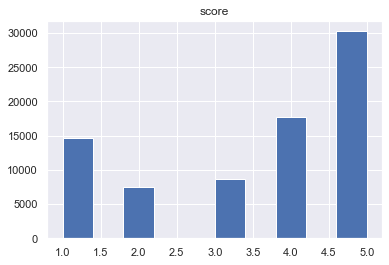

In [183]:
#very intuitive plot of scores distribution of all products
df_copy.hist(column='score')

The data clearly shows that there is the most reviews with score $5.0$, what is quite interesting, but very positive information. In fact, when a customer is satisfied with their purchase, they will not always leave a positive opinion. The other way around, the situation is completely different. Most of customers, who are not satisfied with their purchase, will almost always leave a negative opinion. Therefore based on given data, we can claimed that most of the selling products are of good quality.

There is no such a surprise, that reviews with score $2.0$ and $3.0$ are the least frequent in the data. This is because of the fact, that most of the people treat their purchased product in binary way, i.e. when everything works fine, in most cases customers will rate the product with the highest possible score. The same happens the other way around when the customer is in any way dissatisfied with the purchase, much more often he will give the lowest possible rating.

<b>Therefore based on that observations, I decided to divide all reviews into two groups, such that all reviews with $score >= 4.0$ will be treated as positive opinions and all other will be label as negative one.</b>

In [184]:
#select from dataframe review text and label it based on score
df_copy['label'] = np.where(df_copy['score'] > 3.0, 1, 0)
#from main dataframe we select only text and label column, other columns are not needed for us
reviews = df_copy[['text','label']]
reviews.style.set_properties(subset=['text'])
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78931 entries, 0 to 78930
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78930 non-null  string
 1   label   78931 non-null  int32 
dtypes: int32(1), string(1)
memory usage: 925.1 KB


In [185]:
#we have one example, when text attribute is null, therefore we delete it
reviews.dropna(subset=['text'], inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78930 entries, 0 to 78929
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78930 non-null  string
 1   label   78930 non-null  int32 
dtypes: int32(1), string(1)
memory usage: 1.5 MB


positive examples: 60.78%
negative examples: 39.22%


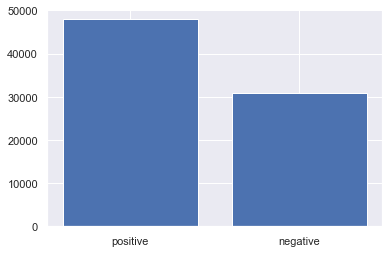

In [186]:
#Count examples of both groups
x = reviews['label'].value_counts()
plt.bar(['positive','negative'], x)
print("positive examples: {:2.2%}".format(x[1]/len(reviews)))
print("negative examples: {:2.2%}".format(x[0]/len(reviews)))

Based on previous observations, there is no thunderbolt that positive opinions are more frequent. Nevertheless, those two groups are quite balanced, therefore there is no need to carry out any data balancing techniques.

In [187]:
char_positive = reviews[reviews['label']==1]['text'].apply(lambda x: len(x))
char_negative = reviews[reviews['label']==0]['text'].apply(lambda x: len(x))
print("Average number of characters in positive reviews: {:.2f}".format(char_positive.mean()))
print("Average number of characters in negative reviews: {:.2f}".format(char_negative.mean()))

Average number of characters in positive reviews: 553.15
Average number of characters in negative reviews: 563.20


In [188]:
word_positive = reviews[reviews['label']==1]['text'].apply(lambda x: len(str(x).split()))
word_negative = reviews[reviews['label']==0]['text'].apply(lambda x: len(str(x).split()))
print("Average number of words in positive reviews: {:.2f}".format(word_positive.mean()))
print("Average number of words in negative reviews: {:.2f}".format(word_negative.mean()))


Average number of words in positive reviews: 102.43
Average number of words in negative reviews: 104.51


In case of length of reviews the difference between positive and negative opinions is not that big. The negative reviews has on average 2 words more and that seems very reasonable, because people usually describe a product defects in a more detailed and honest way.

In [189]:
#copy of df with categorized products
df_categories = df_products.copy() 
#label reviews as positive/negative
df_categories['label'] = np.where(df_products['score'] > 3.0, 1, 0)

In [190]:
categories = ['Accessories','Audio','Battery','Chargers','Data transfer','Holsters','Phones','Phone case']
positives_per = []
negatives_per = []
for category in categories:
    pos = df_categories[df_categories['category']==category]['label'].value_counts()[1]
    neg = df_categories[df_categories['category']==category]['label'].value_counts()[0]
    positives_per.append((pos/(pos+neg))*100)
    negatives_per.append((neg/(pos+neg))*100)

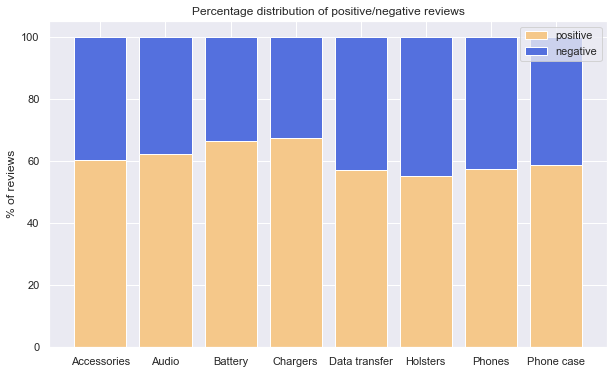

In [191]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(categories, positives_per, color="#F5C88A", label="positive")
ax.bar(categories, negatives_per, bottom=positives_per, color="#5470DE", label="negative")
ax.set_ylabel("% of reviews")
ax.set_title("Percentage distribution of positive/negative reviews")
ax.legend()
plt.show()

Distribution between positive and negative reviews is quite similar in all categories. The highest ratio of $positive/negative$ has the group with chargers, at second place are batteries. We have to remember that actually three of the categories (i.e. accessories, audio and phones) have a lot of more reviews than others, what also influence the results.

# <a name="bonus"></a>Bonus part #
I have in mind that review classification is not actually part of data analysis since I don't analyze data in this part, I just build the model which classify reviews based on text review, but to be honest such a classificator was one of the first ideas, which came to my mind, when I saw data for the first time. I decided to keep this in my solution as a <i>bonus part</i> at the end of my work. 

## <a name="predata"></a> Preprocessing data ##

Important thing in case of working with text data is to preprocess it. It would make our data more clear and in result the model will be more efficient.

In [192]:
# Below functions are actually same as functions in case of product clustering presented above. The only change is that in preprocess
# we keep the first word. I have in mind that there is no need to one more time implement all of this methods, but I want to keep all the 
# sections 'separetly' and independent from each other.

#function, which will clean the data from punctuations, digits and other invalid characters. 
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\w*\d\w*', '', text).strip() 
    text = re.sub(r'\d+', '', text)
    text = ''.join([i for i in text if i not in string.punctuation])
    return text.split()

to_remove = stopwords.words('english')

#function which will remove from given review all stopwords, which occurs in english language (words like 'in','he,'where','when' etc.).
def remove_stopword(text):
    return np.setdiff1d(text, to_remove)

#function which will perform lemmatization of words in given review, i.e. convert different forms of one word into one form,
#so they can be analysis as single word 
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    output = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(output)
    

In [193]:
#perform preprocessing
reviews['text'] = reviews['text'].apply(lambda x: lemmatize_text(remove_stopword(preprocess(x))))
reviews.head()

,text,label
0,actually advice another back buy cant company ...,0
1,buy cell compared data definite easily easy gr...,1
2,advertisedhave doesnt go gooda handset hard li...,1
3,amazon andnothing around benefit better big bu...,1
4,buy cable charger data dont usb,0


## <a name="split"></a>Vectorize data and split it into training and test sets ##



In [194]:
#Create vectorizer, max_features=1500 means that we will take into account only the most 1500 frequent words from our vocabulary
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(reviews['text']).toarray()

In [195]:
#Split our data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, reviews['label'],\
    test_size = 0.2, random_state=12)

## <a name="mlmodel"></a>Building classification model ##
As a first model I would like to try LinearSVC, since its performance in case of text classification is usually very satisficated.

In [196]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(dual=False)
classifier.fit(X_train, y_train)

LinearSVC(dual=False)

## <a name="eval"></a>Model training and evaluation ##

In [197]:
#Testing our model
y_predict = classifier.predict(X_test)
y_prob = classifier._predict_proba_lr(X_test)[:,1]

In [198]:
#evaluate the model
print(classification_report(y_test,y_predict)) 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      6190
           1       0.83      0.88      0.85      9596

    accuracy                           0.82     15786
   macro avg       0.81      0.80      0.81     15786
weighted avg       0.82      0.82      0.82     15786

AUC: 0.8883274516643647


Our model predict the label of unseen data with 88% accuracy, what is actually preety good result.